In [2]:
import rasterio as rio
import numpy as np
import pandas as pd
import os
import xarray as xr

In [2]:
class CombinedNC:
    def __init__(self, start, end, datadir, basingridpath, outputdir, use_previous, precip=None):
        """
        Parameters:
            start: Start date in YYYY-MM-DD format
            :
            :
            datadir: Directory path of ascii format files
        """
        self._start = start
        self._end = end
        self._total_days = (self._end - self._start).days
        self._datadir = datadir
        self._outputpath = outputdir
        self._use_previous = use_previous

        self._rast = rio.open(basingridpath)
        self._ar = self._rast.read(1, masked=True)
        self._gridvalue = self._ar.flatten()

        self._longitudes1d, self._latitudes1d = self._get_lat_long_1d()
        self._latitudes, self._longitudes = self._get_lat_long_meshgrid()

        self.precips = np.zeros((self._total_days+1, self._rast.height, self._rast.width))
        self.tmaxes = np.zeros((self._total_days+1, self._rast.height, self._rast.width))
        self.tmins = np.zeros((self._total_days+1, self._rast.height, self._rast.width))
        self.winds = np.zeros((self._total_days+1, self._rast.height, self._rast.width))
        self.dates = pd.date_range(start, end)

        self._read(precip)
        self._write()


    def _get_lat_long_1d(self):
        x_res, y_res = self._rast.res
        r_lon_0, r_lat_0 = self._rast.xy(self._rast.height-1, 0)
        longitudes1d = (np.arange(0, self._rast.shape[1])*x_res + r_lon_0).round(5)
        latitudes1d = (np.arange(0, self._rast.shape[0])*y_res + r_lat_0).round(5)

        return (longitudes1d, latitudes1d)
    
    def _get_lat_long_meshgrid(self):
        xy = np.meshgrid(self._latitudes1d, self._longitudes1d, indexing='ij')
        longitudes, latitudes = xy[1].flatten(), xy[0].flatten()
        # Need to flip latutudes on horizontal axis
        latitudes = np.flip(latitudes, 0)
        
        return latitudes, longitudes

    def _read(self, precip=None):
        if isinstance(precip, xr.DataArray):
            self.precips = precip
        
        for day, date in enumerate(self.dates):
            fileDate = date
            reqDate = fileDate.strftime("%Y-%m-%d")
            
            if precip is None:
                precipfilepath = os.path.join(self._datadir, f'precipitation/{reqDate}_IMERG.asc')
                precipitation = rio.open(precipfilepath).read(1, masked=True).astype(np.float32).filled(np.nan)#.flatten()[self.gridvalue==0.0]
                self.precips[day, :, :] = precipitation

            #Reading Maximum Temperature ASCII file contents
            tmaxfilepath = os.path.join(self._datadir, f'tmax/{reqDate}_TMAX.asc')
            tmax = rio.open(tmaxfilepath).read(1, masked=True).astype(np.float32).filled(np.nan)#.flatten()[self.gridvalue==0.0]
            self.tmaxes[day, :, :] = tmax

            #Reading Minimum Temperature ASCII file contents
            tminfilepath = os.path.join(self._datadir, f'tmin/{reqDate}_TMIN.asc')
            tmin = rio.open(tminfilepath).read(1, masked=True).astype(np.float32).filled(np.nan)#.flatten()[self.gridvalue==0.0]
            self.tmins[day, :, :] = tmin

            #Reading Average Wind Speed ASCII file contents
            uwndfilepath = os.path.join(self._datadir, f'uwnd/{reqDate}_UWND.asc')
            uwnd = rio.open(uwndfilepath).read(1, masked=True).astype(np.float32).filled(np.nan)
            
            # #Reading Average Wind Speed ASCII file contents
            vwndfilepath = os.path.join(self._datadir, f'vwnd/{reqDate}_VWND.asc')
            vwnd = rio.open(vwndfilepath).read(1, masked=True).astype(np.float32).filled(np.nan)
            wind = (0.75*np.sqrt(uwnd**2 + vwnd**2))#.flatten()[self.gridvalue==0.0]
            self.winds[day, :, :] = wind

    def _impute_basin_missing_data(self, combined_data):
        combine_nomiss_data = combined_data.where(combined_data['extent']==1,-9999)
        try:
            combine_nomiss_data = combine_nomiss_data.interpolate_na(dim="time", method="linear", fill_value="extrapolate")
        except:
            try:
                combine_nomiss_data = combine_nomiss_data.interpolate_na(dim="lon", method="linear", fill_value="extrapolate")
            except:
                print("No inter or extra polation can be done.")
        combine_nomiss_data = combine_nomiss_data.where(combine_nomiss_data!=-9999,combined_data)
        return combine_nomiss_data

    def _write(self):
        precip_da = xr.DataArray(
            data = self.precips,
            coords=[self.dates, np.flip(self._latitudes1d), self._longitudes1d],
            dims=['time', 'lat', 'lon']
        )

        tmax_da = xr.DataArray(
            data = self.tmaxes,
            coords=[self.dates, np.flip(self._latitudes1d), self._longitudes1d],
            dims=['time', 'lat', 'lon']
        )

        tmin_da = xr.DataArray(
            data = self.tmins,
            coords=[self.dates, np.flip(self._latitudes1d), self._longitudes1d],
            dims=['time', 'lat', 'lon']
        )

        wind_da = xr.DataArray(
            data = self.winds,
            coords=[self.dates, np.flip(self._latitudes1d), self._longitudes1d],
            dims=['time', 'lat', 'lon']
        )

        extent_da = xr.DataArray(
            data = self._ar,
            coords=[np.flip(self._latitudes1d), self._longitudes1d],
            dims=['lat', 'lon']
        )

        ds = xr.Dataset(
            data_vars=dict(
                precip = precip_da,
                tmax = tmax_da,
                tmin = tmin_da,
                wind = wind_da,
                extent = extent_da
            )
        )

        if self._use_previous:
            if os.path.isfile(self._outputpath):
                print(f"Found existing file at {self._outputpath} -- Updating in-place")
                # Assuming the existing file structure is same as the one generated now. Basically
                #   assuming that the previous file was also created by MetSimRunner
                existing = xr.open_dataset(self._outputpath).load()
                existing.close()
                last_existing_time = existing.time[-1]
                print("Existing data: %s", last_existing_time)
                existing_to_append = existing.sel(time=slice(ds.time[0] - np.timedelta64(120,'D') , last_existing_time))
                ds = ds.sel(time=slice(last_existing_time + np.timedelta64(1,'D') , ds.time[-1]))
                # ds = ds.isel(time=slice(1, None))
                write_ds = xr.merge([existing_to_append, ds])
                ds = self._impute_basin_missing_data(write_ds)
            else:
                raise Exception('Previous combined dataset not found. Please run RAT without state files first.')
        else:
            print(f"Creating new file at {self._outputpath}")
            ds = self._impute_basin_missing_data(ds)
        ds.to_netcdf(self._outputpath)

In [3]:
from dask.distributed import Client

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45325,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.63 GiB
Comm: tcp://127.0.0.1:39173,Total threads: 4
Dashboard: http://127.0.0.1:40922/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:32954,


In [8]:
# combine IMERG-Final
from pathlib import Path

imerg_dir = Path(f"../../data-ext-hdd/IMERG-Final/namerica/")
imerg_fns = list(imerg_dir.glob("3B-DAY.MS.MRG.3IMERG.*.nc4"))


imerg_ds = xr.open_mfdataset(imerg_fns, chunks={'time': 10}, parallel=True, engine='h5netcdf')
imerg_ds['time'] = [pd.to_datetime(str(time)) for time in imerg_ds['time'].data]
imerg_ds

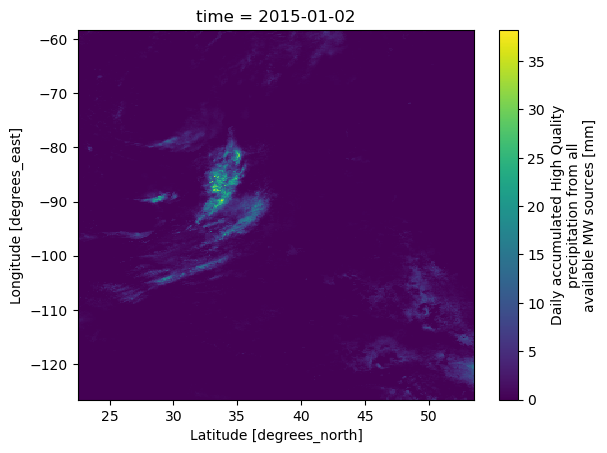

In [7]:
imerg_ds.sel(time='2015-01-02', method='nearest')['HQprecipitation'].plot()

In [6]:
data_dir = Path(f"/home/pdas47/2023_01_24-river-regulation/data-cumberland")
data_dir.exists()

True

In [1]:
imerg_ds

NameError: name 'imerg_ds' is not defined

In [14]:
ncpath_dir = Path(f"../../data-cumberland/tennessee/basins/cumberland/pre_processing/nc")
ncpath = ncpath_dir / 'combined_data.nc'

def create_combined_nc(
        start: str, 
        end: str, 
        ncpath: Path, 
        precip: xr.DataArray, 
        tmax: xr.DataArray, 
        tmin: xr.DataArray, 
        wind: xr.DataArray
    ):
    # convert start and end dates to pd.Timestamp objects
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    date_range = pd.date_range(start, end)

    # check if ncpath exists. load in if it does.
    if ncpath.exists():
        pass
    else:
        

True

ValueError: conflicting sizes for dimension 'time': length 7792 on the data but length 944 on coordinate 'time'